In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nn-text/sample_submission.csv
/kaggle/input/nn-text/train.csv
/kaggle/input/nn-text/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# **Загрузка данных**

In [4]:
train = pd.read_csv('/kaggle/input/nn-text/train.csv')

In [5]:
del train['Unnamed: 0']
train

,Review,Rating
0,foliage silhouette perfect european getaway ho...,4
1,characterized recommendng clean safe hotel hus...,4
2,"seaweed avoidwe spectacular, booked trip bj wh...",5
3,"week__ç_é_ doona ca n't wait return, hotel mag...",5
4,choppy marched super budget hotel hubby stayed...,5
...,...,...
14338,"continential rashes great spot, stayed wife ac...",5
14339,numero profesional best place relaxing holiday...,5
14340,indoors drafted worth just came home new orlea...,4
14341,"fruitstands confine huge room, stayed week bus...",4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14343 entries, 0 to 14342
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  14343 non-null  object
 1   Rating  14343 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 224.2+ KB


In [7]:
print(f'Датасет содержит {train.shape[0]} строки.')

Датасет содержит 14343 строки.


Rating
1       995
2      1255
3      1528
4      4226
5      6334
999       5
Name: count, dtype: int64


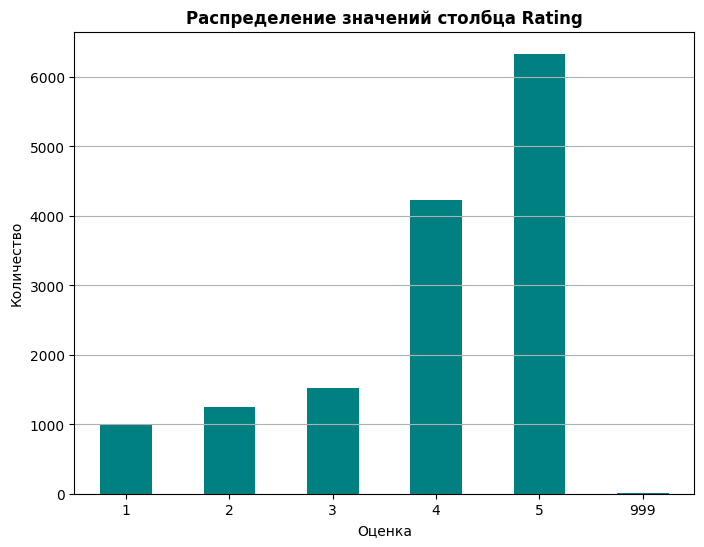

In [8]:
# Вывод распределения значений столбца Rating
rating_distribution = train['Rating'].value_counts().sort_index()

print(rating_distribution)

plt.figure(figsize=(8, 6))
rating_distribution.plot(kind='bar', color='teal')
plt.title('Распределение значений столбца Rating', fontweight='bold')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [9]:
# Удаление строк с рейтингом 999 (предполагаю, что они ошибочные)
train = train[train['Rating'] != 999]

In [10]:
test = pd.read_csv('/kaggle/input/nn-text/test.csv')

In [11]:
test

,index,Review
0,0,"saefood bubbas want iwant ro riu wow, riu bamb..."
1,1,raging she__ç_éö enjoyably different just retu...
2,2,"boading terrifying best vacation, husband went..."
3,3,blended enthusastic location location location...
4,4,peptol insulated love hk good hotel stay noise...
...,...,...
6143,6143,particapated activce loved antiche figure husb...
6144,6144,ubiquitous osmond blissfull stay tegal sari ju...
6145,6145,rican feeder nice hotel trip seattle wanted st...
6146,6146,maintanace disembark basic good value chose ho...


# **Предобработка данных**

In [12]:
from transformers import BertTokenizer, BertModel

In [13]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Rating'])

In [14]:
class ReviewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data.iloc[index, 0])
        rating = int(self.data.iloc[index, 1]) - 1  # Rating начинается с 1, но для классификации лучше с 0
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'rating': torch.tensor(rating, dtype=torch.long)
        }

**ReviewsDataset** включает в себя методы для токенизации текстов с помощью предобученной модели BERT и подготовки данных для подачи в модель. Основное внимание уделено правильной токенизации, добавлению специальных токенов [CLS] и [SEP], паддингу до фиксированной длины и созданию attention_mask.

In [15]:
# Загрузка модели и токенайзера BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
# Создание DataLoader
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = ReviewsDataset(train_df, tokenizer, MAX_LEN)
test_dataset = ReviewsDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [17]:
# Создание классификатора на основе BERT
class Classifier(nn.Module):
    def __init__(self, bert_model, n_classes):
        super(Classifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

Для извлечения эмбеддингов текстов была использована предобученная модель BERT (bert-base-uncased).

После получения эмбеддингов модель BERT использовала полносвязный слой для классификации текстов на основе рейтинга.

In [18]:
# Инициализация модели, потерь и оптимизатора
model = Classifier(bert_model, n_classes=5)
model = model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [19]:
EPOCHS = 7

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        ratings = batch['rating'].to('cuda')
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_loader)}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/7, Loss: 0.9340685119273108
Epoch 2/7, Loss: 0.7195193051793086
Epoch 3/7, Loss: 0.5688079739589571
Epoch 4/7, Loss: 0.41702181308671854
Epoch 5/7, Loss: 0.26707828116591503
Epoch 6/7, Loss: 0.17386987857453037
Epoch 7/7, Loss: 0.11242188148348588


In [20]:
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        ratings = batch['rating'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
        predictions.extend(preds.cpu().numpy())  # Переносим на CPU и конвертируем в numpy
        true_labels.extend(ratings.cpu().numpy())  # Переносим на CPU и конвертируем в numpy
        
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6342


# **Предобработка тестовых данных и формирование сабмита**

In [21]:
class ReviewsTestDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data.iloc[index, 1])
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,  # Обязательно добавляем обрезку
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

Был создан отдельный класс **ReviewsTestDataset**, который не требует наличия целевой переменной. 

Важно, чтобы все предложения в батче имели одинаковую длину, что достигается путем паддинга до фиксированной длины (max_len) и использования обрезки (truncation), если текст превышает максимальную длину.

In [22]:
# Создание DataLoader для тестового набора данных
test_dataset = ReviewsTestDataset(test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [23]:
# Функция для предсказания рейтингов на тестовом наборе
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
    
    return predictions

In [24]:
test_predictions = predict(model, test_loader)

In [25]:
submission_df = pd.DataFrame({
    'index': test['index'],
    'Rating': [pred + 1 for pred in test_predictions]
})

submission_df.to_csv('submission_1.csv', index=False)

In [26]:
submission_df

,index,Rating
0,0,5
1,1,4
2,2,5
3,3,5
4,4,4
...,...,...
6143,6143,5
6144,6144,5
6145,6145,4
6146,6146,3


Скор после загрузки сабмита: **0.638162**